# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

We first need to import the dataset from the drive. You can change the path if the zip file is not at this location.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

We then load all the libraries needed for the project.

In [2]:
import os # for the file.
import cv2 # for the detection.
import matplotlib.pyplot as plt # for the image visualisation.
import numpy as np # for the operations on the images.

We then create a function to split the images in two categories : one for each track. The function load_and_split_images will return images_first_part (1-5 for the scenes images and 1-14 for the models images), images_second_part (6-12 for the scenes images and 15-27 for the models images).

In [33]:
def load_and_split_images(folder, split_point, color_mode=cv2.IMREAD_COLOR):
    images_first_part = []
    images_second_part = []

    # Function to extract the number from the filename
    def extract_number(filename):
        return int(''.join(filter(str.isdigit, filename)))

    # Sort files numerically by extracting the number from the filename
    sorted_filenames = sorted(os.listdir(folder), key=extract_number)

    for filename in sorted_filenames:
        img_path = os.path.join(folder, filename)
        if img_path.endswith(".png"):
            img = cv2.imread(img_path, color_mode)
            if img is not None:
                number = extract_number(filename)
                if number <= split_point:
                    images_first_part.append(img)
                else:
                    images_second_part.append(img)
            else:
                print(f"Failed to load image at {img_path}")
    return images_first_part, images_second_part


# **Track A - Single Instance Detection**

Before making any detections, we observed that the scene images have a lot of noise, which makes detection harder. We tried three types of filtering: median, bilateral, and gaussian. The best result was obtained with median filtering. We apply this filtering before converting to grayscale because it gives better results. At the end of the function, we convert the scene images to grayscale.

Moreover, the best kernel size was 5. With either lower or higher values, the detection was less accurate and struggled more, even if we adjusted the hyperparameters.

In [4]:
def apply_median_filter(images, kernel_size=5):
    filtered_images = []
    for img in images:
        filtered_img = cv2.medianBlur(img, kernel_size)
        filtered_images.append(cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY))  # Convert to grayscale
    return filtered_images

Our approach involves using a SIFT detector on the scene images, pre-filtered by a median filter (as explained above)(inspired from the one of the practical session). A while loop iterates through each product, selecting the one with the maximum matching points. Once a product is detected, homography is applied. The loop stops if the number of matching points is too low (inferior to 25) or if any angle is either above 120 degrees or below 60 degrees, indicating the homography does not match the rectangular shape of the products.

If these two conditions are not met, the loop continues. To ensure we detect a genuine product and not a false positive, we added one final constraint. If all angles are not between 85 and 95 degrees, we discard the detected product and apply a black mask to the image. This implies that although a product was detected, it does not match any from our database, as the angles are outside the 85 to 95 degrees range.

A black mask is then applied to the image to prevent distortion in the calculation of matching points for subsequent detections. Conversely, if all angles are within the 85 to 95 degrees range, a black mask is still applied to ensure these points are excluded from the next wave of detections.

This function is used for the angles calcuation. This will be used in our two angles constraints describe above.

In [5]:
# Calculate the angle in degrees between vectors 'v1' and 'v2'
def angle_between_vectors(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
    return np.degrees(np.arccos(dot_product))

Finally, here is the function for the SIFT descriptor incorporating all the specificities mentioned earlier. For the line good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance], we used a threshold of 0.7 because a lower threshold did not yield enough points for scene 4, while a higher threshold caused the detection to retrieve points from other products.

In [6]:
def detect_and_mask_products(scene_image, model_images):
    # Create a SIFT detector object
    sift = cv2.SIFT_create()

    # Set parameters for the FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    detections = []
    masked_image = scene_image.copy()
    scene_height, scene_width = scene_image.shape[:2]

    while True:
        # Detect keypoints and compute descriptors for the scene image
        scene_keypoints, scene_descriptors = sift.detectAndCompute(masked_image, None)
        max_matches = 0
        best_match = None
        best_model_keypoints = None
        best_homography = None

        # Iterate through each model image to find the best match
        for model_idx, model in enumerate(model_images):
            model_keypoints, model_descriptors = sift.detectAndCompute(model, None)
            matches = flann.knnMatch(model_descriptors, scene_descriptors, k=2)
            good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

            # Check if the current model has more good matches than previous best
            if len(good_matches) > max_matches:
                max_matches = len(good_matches)
                best_match = model_idx
                best_model_keypoints = model_keypoints

                if len(good_matches) > 10:
                    src_pts = np.float32([model_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    dst_pts = np.float32([scene_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                    best_homography = homography

        # Stop if the number of matches is below a threshold
        if max_matches < 25:
            break

        if best_homography is not None:
            # Calculate coordinates of model in the scene and mask it
            h, w = model_images[best_match].shape[:2]

            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, best_homography)

            # Calculate angles between consecutive corners
            angles = []
            num_corners = len(dst)
            for i in range(num_corners):
                v1 = dst[i][0] - dst[i - 1][0]
                v2 = dst[(i + 1) % num_corners][0] - dst[i][0]
                angle = angle_between_vectors(v1, v2)
                angles.append(angle)

            # Print angles and number of matches
            print(angles)
            print(max_matches)

            # Stop if any angle is less than 60 degrees or greater than 120 degrees
            if any(60 > angle or angle > 120 for angle in angles):
                break

            # Skip detection if angles are not close to 90 degrees
            if not all(85 <= angle <= 95 for angle in angles):
                # Mask the detected area for processing but don't add to detections
                cv2.fillConvexPoly(masked_image, dst.astype(int), 0)
                continue

            position = tuple(np.int32(dst[0, 0]))
            width = int(np.linalg.norm(dst[0][0] - dst[1][0]))
            height = int(np.linalg.norm(dst[0][0] - dst[3][0]))

            detection_details = (best_match, max_matches, position, width, height, dst)
            detections.append(detection_details)

            # Mask the detected area
            cv2.fillConvexPoly(masked_image, dst.astype(int), 0)

    return masked_image, detections

Now, we just need a function to draw green boxes around the detected products.

In [7]:
def draw_detections_on_image(image, detections, model_images):
    for detection in detections:
        best_match, max_matches, position, width, height, dst = detection
        color = (0, 255, 0)  # Green color for the rectangle
        cv2.polylines(image, [np.int32(dst)], True, color, 3)
        label = f'Product {best_match+1}'
        cv2.putText(image, label, position, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    return image

Execution part: First, we load the images (scenes and products), then filter them. We apply the SIFT detector to each scene in a loop, and finally, add the green boxes to the original images.

[90.10386654349448, 90.04261472142937, 89.97621905654312, 89.87729969324033]
685
[89.96061068282002, 90.05458659996002, 89.96598758359652, 90.01881513378399]
536
Product 1 {match: 685, position: (10, 14), width: 1049px, height: 801px}
Product 2 {match: 536, position: (846, 9), width: 1048px, height: 802px}


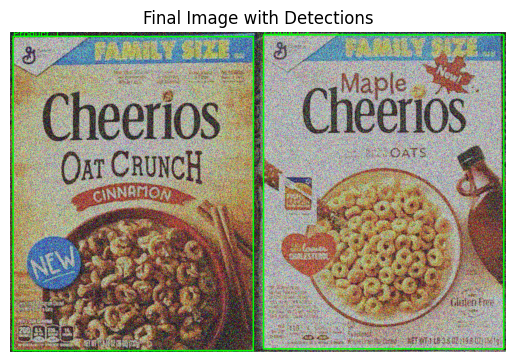

[89.96025066706488, 90.03227574379983, 90.02675323496624, 89.98072035329584]
304
[89.94593512934355, 89.92130681118059, 90.13458595979284, 89.99817212398392]
308
[89.91860639587325, 90.02317590970807, 89.98554653249039, 90.07267117119054]
252
Product 5 {match: 304, position: (1247, 28), width: 843px, height: 560px}
Product 3 {match: 308, position: (3, 24), width: 939px, height: 603px}
Product 4 {match: 252, position: (611, 8), width: 949px, height: 632px}


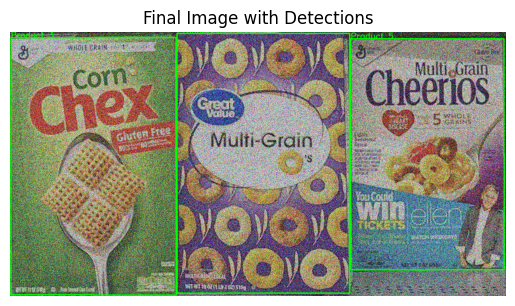

[89.90590360313702, 90.05520359510992, 89.88285537061043, 90.15603743861524]
162
[90.22803924741429, 90.1967495219041, 89.5643560118468, 90.01085524505925]
128
[89.92434125220451, 90.02892740983386, 90.00228733964019, 90.04444399202542]
94
[176.37420346665664, 179.98021765897056, 172.5892876518004, 176.1964585139581]
31
Product 8 {match: 162, position: (1168, 9), width: 778px, height: 558px}
Product 6 {match: 128, position: (-3, 122), width: 672px, height: 601px}
Product 7 {match: 94, position: (618, 136), width: 649px, height: 541px}


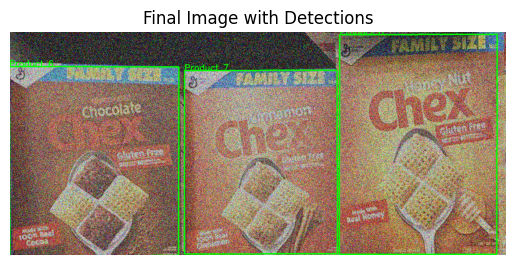

[89.06519591323223, 89.86376817346418, 90.48745358958837, 90.58358230684091]
231
[89.70717365450955, 89.59347955134614, 90.44660644652613, 90.25274033721718]
72
[89.12979905765944, 89.83630475559266, 90.51700676601479, 90.51688942072309]
55
[88.17529254414512, 89.82308533293512, 91.77198935382405, 90.22963261518998]
34
[88.57461084809748, 90.93453948845283, 90.12353559279885, 90.36731421473945]
28
[71.87402893305476, 74.02431851670937, 131.26603108243665, 82.83562225715563]
29
Product 1 {match: 231, position: (696, 664), width: 504px, height: 374px}
Product 9 {match: 72, position: (11, 711), width: 462px, height: 327px}
Product 8 {match: 55, position: (176, 16), width: 483px, height: 346px}
Product 10 {match: 34, position: (807, 97), width: 398px, height: 264px}
Product 7 {match: 28, position: (-169, 96), width: 404px, height: 339px}


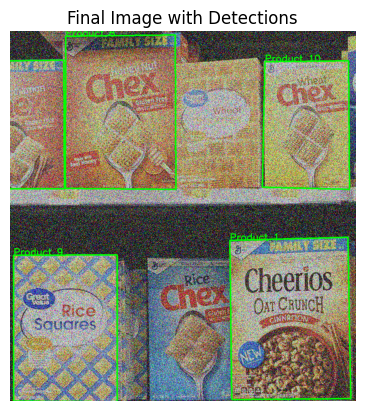

[90.02115917447513, 89.92369637239005, 90.0027992869984, 90.0523451696882]
162
[88.16021722571016, 89.33861137092627, 90.05489509253158, 92.4462761672482]
81
[95.08974298122192, 88.41225998604178, 87.78658538672059, 88.71141183184373]
60
[159.34047542450742, 59.036053972795166, 119.35184995712883, 140.3437292872573]
36
Product 11 {match: 162, position: (185, 475), width: 552px, height: 366px}
Product 12 {match: 81, position: (499, 420), width: 637px, height: 436px}


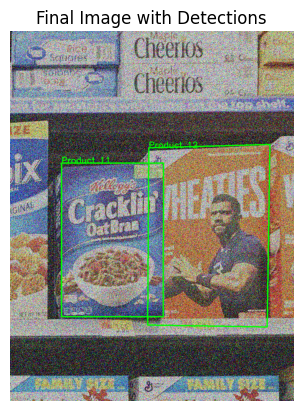

In [35]:
# Setup paths
scenes_folder = '/content/dataset/scenes'
models_folder = '/content/dataset/models'

# Load and separate images
model_images_first_part, _ = load_and_split_images(models_folder, 14)
scene_images_first_part, _ = load_and_split_images(scenes_folder, 5, cv2.IMREAD_COLOR)

# Apply median filter and convert to grayscale
filtered_scene_images = apply_median_filter(scene_images_first_part, kernel_size=5)

# Detect products and mask them iteratively
for scene_image, original_image in zip(filtered_scene_images, scene_images_first_part):
    result_image, product_detections = detect_and_mask_products(scene_image, model_images_first_part)
    final_image = draw_detections_on_image(original_image, product_detections, model_images_first_part)
    for detection in product_detections:
        best_match, max_matches, position, width, height, dst = detection
        print(f"Product {best_match + 1} {{match: {max_matches}, position: {position}, width: {width}px, height: {height}px}}")

    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))  # Display the final image with detections
    plt.title('Final Image with Detections')
    plt.axis('off')
    plt.show()

**Additional details :**

Product 7 in scene 4 may sometimes not be detected because it is partially cut off, resulting in fewer matching points.

In scene 5, sometimes (1/10 in testing) the Cheerios can be detected as a product. It is when its shape is detected as a rectangle. The product where "Family Size" is written can be also detected sometimes but as the Cheerios it is really rare.

Overall, the model have great results and most of the time is 100 % accurate.

# **Track B - Multiple Instances Detection**

For this track, since we previously used a black mask after each object detection, the method also works for this track. However, we have made a few changes. In this part, we detect fewer matching points for the products. This can be a consequence of multiple instances of one product, resulting in more products in the images than before, which are usually smaller.

Therefore, we decided to increase the detection parameter to good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance], raising it from 0.7 to 0.75. A higher value starts to detect too many points, including those from other products, making it less accurate. Additionally, since we have fewer points, we decided to remove the constraint where an object with any angle greater than 95 or less than 85 degrees would be masked but not counted as a detection. We tried a higher interval, but with fewer good matching points, the shape can sometimes deviate from being perfectly rectangular.

Finally, we lowered the number of matching points needed for detection from 25 to 15. Additionally, we added one last constraint. Since there are fewer good matches detected, if the number of max_matches is below 70 (which is low) and the ratio between the current matching points and the previous should be higher than 0.6. Otherwise, it is too low and inaccurate.

In [29]:
def detect_and_mask_products_taskb(scene_image, model_images):
    # Create a SIFT detector object
    sift = cv2.SIFT_create()

    # Set parameters for the FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    detections = []
    masked_image = scene_image.copy()
    scene_height, scene_width = scene_image.shape[:2]

    current_matches = 1
    past_matches = 1

    while True:
        # Detect keypoints and compute descriptors for the scene image
        scene_keypoints, scene_descriptors = sift.detectAndCompute(masked_image, None)
        max_matches = 0
        best_match = None
        best_model_keypoints = None
        best_homography = None

        # Iterate through each model image to find the best match
        for model_idx, model in enumerate(model_images):
            model_keypoints, model_descriptors = sift.detectAndCompute(model, None)
            matches = flann.knnMatch(model_descriptors, scene_descriptors, k=2)
            good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]  # Increased distance threshold to 0.75

            # Check if the current model has more good matches than the previous best
            if len(good_matches) > max_matches:
                max_matches = len(good_matches)
                best_match = model_idx
                best_model_keypoints = model_keypoints

                # Compute homography if enough good matches are found
                if len(good_matches) > 15:
                    src_pts = np.float32([model_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    dst_pts = np.float32([scene_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                    best_homography = homography

        print(max_matches)
        # Stop if the number of matches is below a threshold
        if max_matches < 10:
            break

        current_matches = max_matches  # Set the current number of matches

        # Check if the current number of matches is significantly lower than the previous
        if current_matches / past_matches < 0.6 and past_matches < 70:
            break  # Stop the loop if conditions are met

        past_matches = max_matches  # Update the number of past matches

        if best_homography is not None:
            # Calculate coordinates of the model in the scene and mask it
            h, w = model_images[best_match].shape[:2]

            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, best_homography)

            # Calculate angles between consecutive corners
            angles = []
            num_corners = len(dst)
            for i in range(num_corners):
                v1 = dst[i][0] - dst[i - 1][0]
                v2 = dst[(i + 1) % num_corners][0] - dst[i][0]
                angle = angle_between_vectors(v1, v2)
                angles.append(angle)

            print(angles)

            # Stop if any angle is less than 60 degrees or greater than 120 degrees
            if any(60 > angle or angle > 120 for angle in angles):
                break

            # Calculate position, width, and height of the detected product
            position = tuple(np.int32(dst[0, 0]))
            width = int(np.linalg.norm(dst[0][0] - dst[1][0]))
            height = int(np.linalg.norm(dst[0][0] - dst[3][0]))

            detection_details = (best_match, max_matches, position, width, height, dst)
            detections.append(detection_details)

            # Mask the detected area
            cv2.fillConvexPoly(masked_image, dst.astype(int), 0)

    return masked_image, detections



We modified draw_detections_on_imageb to display the correct numbers associated with the boxes. This adjustment was necessary because the images in track B start at 15 instead of 1.

In [10]:
def draw_detections_on_imageb(image, detections, model_images):
    for detection in detections:
        best_match, max_matches, position, width, height, dst = detection
        color = (0, 255, 0)  # Green color for the rectangle
        cv2.polylines(image, [np.int32(dst)], True, color, 3)
        label = f'Product {best_match+15}'
        cv2.putText(image, label, position, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    return image

As before, but we use detect_and_mask_products_taskb and draw_detections_on_imageb described just above :


Execution part: First, we load the images (scenes and products), then filter them. We apply the SIFT detector to each scene in a loop, and finally, add the green boxes to the original images.

51
[91.89317686697723, 95.65506738662634, 84.7036159750011, 87.74814044331228]
51
[89.48442992655474, 85.75833101187743, 94.6106611654449, 90.14657836735294]
45
[90.00731699358073, 91.34651730068884, 88.78890478989405, 89.8572609582501]
39
[89.03114474886657, 88.05455459998899, 92.09054589331959, 90.82375479551706]
18
Product 22 {match: 51, position: (1135, 183), width: 722px, height: 245px}
Product 21 {match: 51, position: (861, 190), width: 691px, height: 246px}
Product 22 {match: 45, position: (1401, 188), width: 697px, height: 250px}
Product 21 {match: 39, position: (588, 189), width: 696px, height: 245px}


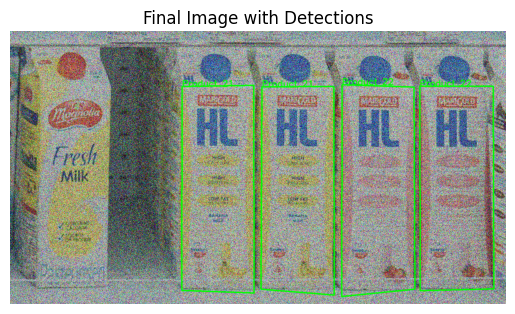

62
[89.9914772445655, 90.61620465193953, 89.44286538954115, 89.94945263821178]
53
[89.82449880191156, 88.96787570220543, 91.26651401949088, 89.94111147932021]
50
[90.37723668802984, 88.42892931253085, 91.81048710430039, 89.38334687749783]
43
[89.25032153863724, 90.29169574771113, 89.61525671474995, 90.84272589120373]
47
[88.5764780944879, 89.03582014494636, 90.9264160416699, 91.46128592869722]
35
[91.2651919485172, 90.3013721742981, 89.06341278263967, 89.37002289791523]
30
[89.52845159653411, 89.94550996655221, 90.56744591789729, 89.9585924548]
17
Product 17 {match: 62, position: (75, 121), width: 480px, height: 182px}
Product 17 {match: 53, position: (266, 126), width: 477px, height: 183px}
Product 24 {match: 50, position: (462, 127), width: 479px, height: 186px}
Product 25 {match: 43, position: (1248, 138), width: 477px, height: 185px}
Product 25 {match: 47, position: (850, 135), width: 470px, height: 188px}
Product 25 {match: 35, position: (1049, 128), width: 481px, height: 184px}
P

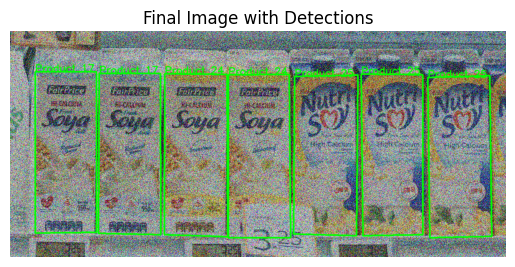

48
[88.22420536769762, 88.20077100415281, 92.2395869530942, 91.33543655290566]
40
[90.43549897584516, 90.60837397989023, 89.35868798167975, 89.59743899864301]
26
[94.93455031060938, 94.15582900106466, 85.08551786617078, 85.82410339022417]
24
[85.95395583444319, 92.9368067606973, 86.53353298076888, 94.57570468910609]
13
Product 26 {match: 48, position: (295, 105), width: 582px, height: 227px}
Product 26 {match: 40, position: (28, 86), width: 590px, height: 230px}
Product 27 {match: 26, position: (823, 86), width: 610px, height: 259px}
Product 27 {match: 24, position: (586, 108), width: 578px, height: 240px}


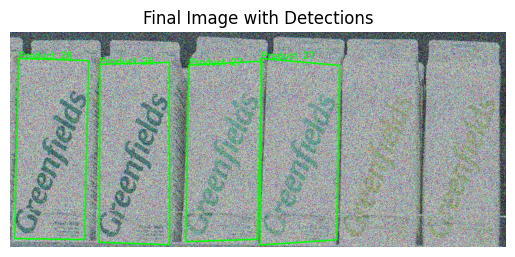

65
[91.03231984369233, 89.95994139082157, 89.9704539610428, 89.03728489399278]
55
[88.92564689843502, 90.51781276120109, 90.01235880051215, 90.5441814655853]
30
Product 15 {match: 65, position: (418, 164), width: 908px, height: 326px}
Product 15 {match: 55, position: (24, 168), width: 910px, height: 333px}


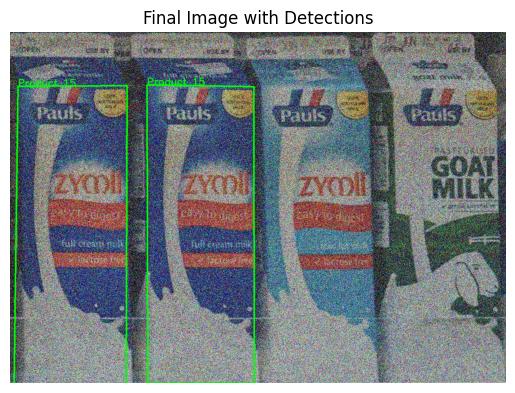

172
[90.0578208695113, 89.34404092968327, 90.64928266091106, 89.94885564342466]
127
[89.52589397712674, 89.49247786434698, 90.40557060162033, 90.57605766775721]
23
[174.20799620660142, 5.322333433955161, 179.36295619390253, 11.751247055661219]
Product 16 {match: 172, position: (916, 164), width: 599px, height: 215px}
Product 16 {match: 127, position: (687, 162), width: 596px, height: 216px}


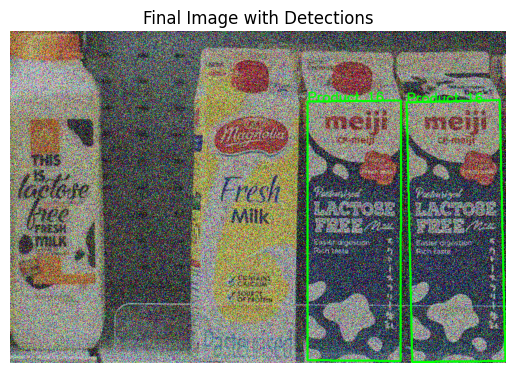

148
[89.58254712405424, 89.85764934641983, 90.2504502540949, 90.30935328365779]
138
[89.5793029909057, 90.86969641068166, 89.03932004343072, 90.51168055131633]
94
[89.96425593688792, 89.86255593149119, 90.05826862732778, 90.11491950394148]
47
[93.20919647135702, 88.67233061583015, 91.19451159192869, 86.92396026619645]
12
Product 17 {match: 148, position: (825, 150), width: 850px, height: 326px}
Product 17 {match: 138, position: (485, 142), width: 853px, height: 327px}
Product 24 {match: 94, position: (1174, 153), width: 851px, height: 327px}
Product 26 {match: 47, position: (154, 157), width: 763px, height: 303px}


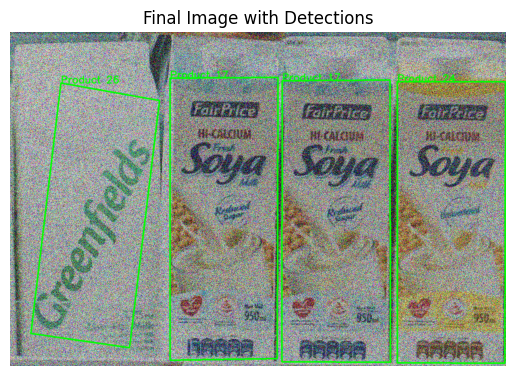

48
[90.83303644524773, 89.1894487160155, 90.02468517153797, 89.95282965438649]
35
[88.13810127442358, 88.40475540900326, 91.02031823641026, 92.4368254917094]
32
[90.33128170868096, 88.86045167134549, 90.93974425518242, 89.86852226490572]
21
[90.44510378609336, 94.34011953124481, 85.21356781623695, 90.00120873003976]
10
Product 19 {match: 48, position: (733, 91), width: 566px, height: 227px}
Product 19 {match: 35, position: (503, 98), width: 550px, height: 231px}
Product 20 {match: 32, position: (1245, 98), width: 553px, height: 229px}
Product 20 {match: 21, position: (986, 96), width: 562px, height: 232px}


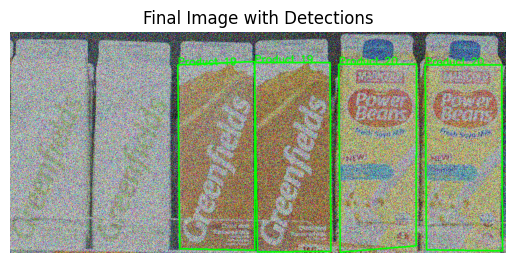

In [31]:
# Setup paths
scenes_folder = '/content/dataset/scenes'
models_folder = '/content/dataset/models'

# Load and separate images
model_images_first_part, model_images_second_part = load_and_split_images(models_folder, 14)
scene_images_first_part, scene_images_second_part = load_and_split_images(scenes_folder, 5, cv2.IMREAD_COLOR)

# Apply median filter and convert to grayscale
filtered_scene_images = apply_median_filter(scene_images_second_part, kernel_size=5)

# Detect products and mask them iteratively
for scene_image, original_image in zip(filtered_scene_images, scene_images_second_part):
    result_image, product_detections = detect_and_mask_products_taskb(scene_image,model_images_second_part)
    final_image = draw_detections_on_imageb(original_image, product_detections, model_images_second_part)
    for detection in product_detections:
        best_match, max_matches, position, width, height, dst = detection
        print(f"Product {best_match + 15} {{match: {max_matches}, position: {position}, width: {width}px, height: {height}px}}")

    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))  # Display the final image with detections
    plt.title('Final Image with Detections')
    plt.axis('off')
    plt.show()

# **Observations**

We can observe that the results are generally good. We correctly detect most instances, except for the Greenfields products (ref 18 and 27). These two products present challenges for our method. Firstly, ref 18 is never detected. Secondly, ref 27 is detected less frequently, has poor shape recognition, or is sometimes misidentified as product 26, which is similar but with a less bright green color. This can be explained by several factors.

Firstly, in this track, there are more products to detect in each image, and they are smaller, resulting in fewer matching points. Secondly, these products are primarily white with minimal details, making it harder for SIFT to detect edges and corners. Lastly, the images are very noisy, and despite using a median filter, the details on these products are difficult to discern. This is particularly true for ref 18, which is barely visible even after denoising. This represents the first limitation of our model. One potential solution would be to use a SURF detector; however, this requires a license and is not feasible on Colab (for us). Alternatively, we could improve our understanding of the noise and use better denoising methods to produce clearer images with more visible details.

Products 17 and 23 are the same. Sometimes 23 is detected, and other times it is 17. Due to our method of applying a black mask, we cannot detect both simultaneously. Although this is not a major issue, it represents the second limitation of our model.

Finally, the products in this part are often very similar, with color being the main difference. As mentioned earlier, since we do not have as many good matches as in part A, the model can occasionally make mistakes and misidentify two products of the same brand but with different colors. However, this is rare and happened only twice in 14 attempts during testing. We found that a detection distance of 0.75 was optimal. Similarly, a kernel size of 5 for the median filter proved to be the most effective (applying the median filter before grayscale conversion also yielded better results).